# What's really going on in PBjam - an advanced tutorial

## Introduction

PBjam is a code for 'peakbagging' solar-like oscillations.  The code has been designed to provide automated peakbagging data analysis relying on probablilistic methods.  The aim is to achieve a peakbagging code that will work, and not just on high signal-to-noise targets but also on lower signal-to-noise examples.  We aim to achieve a code that works on a wide variety of solar-like oscillations including main sequence, sub giant, and red giant stars.  And we aim to provide all this functionality in an easy to use interface that requires little user expertise.

The current state of PBjam reflects it's developmental nature.  Currently functionality is provided for peakbagging radial and quadrupole modes.  Additional functionality for dipole and octupole modes is under developement and will be released as part of version 2.0. 

In this example we will demonstrate what is happening under the hood of PBjam.  As such this consititutes an advanced tutorial that relies somewhat on basic knowledge of solar-like peakbagging and it's terminology.  There are many resouces in the scientific literature if the user requires more background ([Davies 2016](http://adsabs.harvard.edu/abs/2016MNRAS.456.2183D), [Basu & Chaplin](https://press.princeton.edu/titles/11170.html)). 

This example will look at a high signal-to-noise ratio red giant with nearly 4 years of high quality Kepler data (KIC 4448777).  We will use the excellent Lightkurve tool to handle the data and refer the user to the excellent [Lightkurve docs](https://www.docs.lightkurve.org) for details and functionality.

In [1]:
import pbjam as pb
import lightkurve as lk 

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


KIC 4448777 has already been extensively studied and the interested reader can find more [here](https://ui.adsabs.harvard.edu/abs/2016ApJ...817...65D/abstract).  Table 2 of this work lists mode frequencies that we can use as a comparison with our results later.

## Setup

We start by setting up the exisiting knowledge of the star.  We take exisiting values of $\nu_{\rm max}$, $\Delta {\nu}$, Teff, and Gaia $G_{\rm bp} - G_{\rm rp}$.  Each observable is set up as a tuple in the form (value, uncertainty).  

We will use all four of the observed quantities but PBjam can be run with some subset of the observables.  It is recommended that as an absolute minimum, at least $\nu_{\rm max}$ and $\Delta {\nu}$ should be provided for rediants and subgiants, while at least $\Delta {\nu}$ and Teff should be provided for main sequence stars.  PBjam will work best if all 4 observed properties are provided and the provided values are accurate.

In [2]:
kic = '4448777'
numax = (220.0, 3.0)  # in microhertz
dnu = (16.97, 0.05)   # in microhertz
teff = (4750, 250)    # in Kelvin
bp_rp = (1.34, 0.1)   # in mag

### Data collection and preparation

We handle all of our data in this tutorial using [lightkurve](https://docs.lightkurve.org/index.html).  First we download all available lightcurves:

In [3]:
lcs = lk.search_lightcurvefile(kic).download_all()

We then process the lightcurve collection by concatenating, normalizing, flattening, and the finally removing outliers:

In [4]:
lc = lcs.PDCSAP_FLUX.stitch().normalize().flatten(window_length=401).remove_outliers(4)

Lightkurve provides plot functionality for it's lightcurve objects and so to plot the time series data we simply:

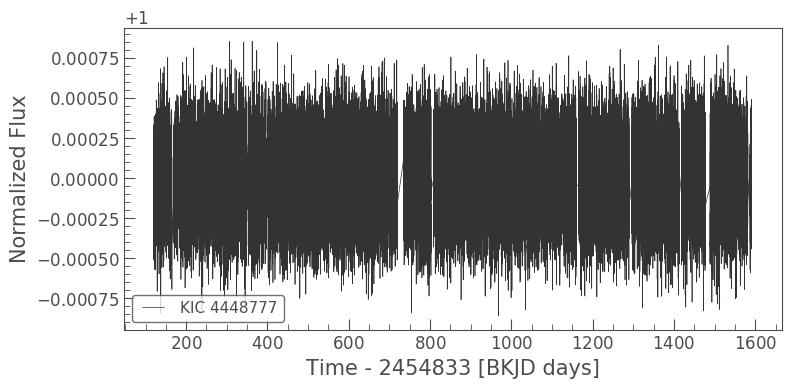

In [5]:
lc.plot();

We then use the lightkurve periodogram functionality to get a critically sampled power spectrum with frequency units of $\mu \rm Hz$ (i.e., normalization='psd').  We set the maximum and minimum frequency of the periodogram based on the estimated numax and dnu and finally we flatten the periodogram.

The flatten function uses lightkurves inbuilt method to remove the broadband background power but maintain the modes of oscillation.  The lightkurve method uses a simple estimation of the background based on a varying width median filter in log space, and divides the power by the estimated background to produce what is commonly referred to as a signal-to-noise spectrum.  The lightkurve implementation is less than optimal but fast and easy to use.  If you care about the treatment of the background and worry about it's impact on your results then you can implement your own method here (for example background fitting) to produce a flattened periodogram.

In [6]:
pg = lc.to_periodogram(normalization='psd', 
                      minimum_frequency=numax[0] - dnu[0] * 4,
                      maximum_frequency=numax[0] + dnu[0] * 4).flatten()

/Users/davies/Library/Python/3.6/lib/python/site-packages/lightkurve/periodogram.py:752: LightkurveWarning: Input light curve will be normalized.
  LightkurveWarning)


Again, a lightkurve periodogram has a plot function:

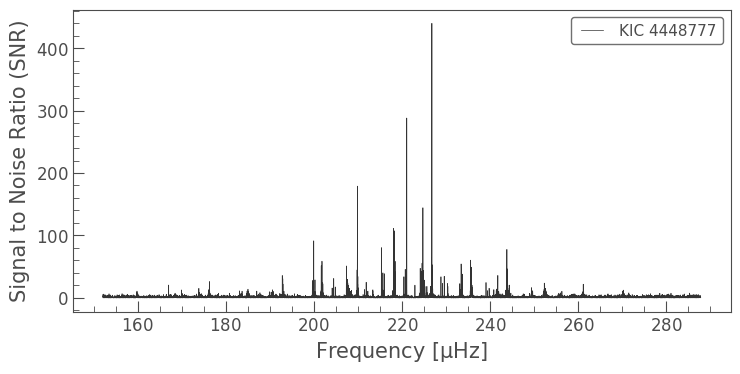

In [ ]:
pg.plot()

At this stage our setup is complete.  We have some observed properties and we have some data.  We move on to using PBjam to try to understand and interpret the data we have.

## PBjam

### Motivation

Most of the effort in PBjam (both computational and developmental) is applied to determining mode degree identification given some periodogram.  For this task we break up what we know into two components:

\begin{align*}
P(M \, | \, D) \propto P(M) \, P(D \, | \, M),
\end{align*}

where $P(M \, | \, D)$ is the posterior probability of some model $M$ given the data $D$, $P(M)$ is the prior constraint on $M$, and $P(D \, | \, M)$ is the probability of $M$ given the data.  If we use a more informal syntax then the prior is what we know already, the likelihood tells us what we know from the data, and the posterior is what we care about: the combination of our exisiting knowledge and our new knowledge. 

For peakbagging solar-like oscillations we have a wealth of experience and exisiting knowledge.  The *Kepler* mission has provided excllent data sets for thousands of solar-like oscillators.  PBjam uses this exisiting data set to generate a prior probability function $P(M)$.  In PBjam we call the prior function `epsilon` because, well because.

For the likelihood function to provide a model to compare with the data, we use a simple asymptotic relation that describes the well established pattern of radial and quadrupole modes in the periodogram.  The pattern is not much more than the sum of regularly spaced Lorentzian profiles in addition to some background.  This pattern provides a simple model than can be used as $M$ and allows for the easy evaluation of $P(D \, | \, M)$.  We use `asy_peakbag` to estimate $P(M \, | \, D)$ and hence make a mode identification.

Once mode identification is complete, we perform the actual peakbagging using `peakbag`.  This peakbagging uses a new model and is powered by the NUTS sampler of [pymc3](https://docs.pymc.io/). Here we try to minimise the prior constraints from the previous steps leaking through into the fit.  But, there is a trade off between speed and stability vs minimum prior constraint.  We will discuss the priors in more detail in the `peakbag` section.

### `epsilon`

The prior function we build is a continuous function based on previously fitted solar-like oscillator examples.  There are many way of building a prior function but here we use a [Kernel Density Estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE) approach where previous results are used as input.  

A KDE is fundamentally a data smoothing problem and many users will be familar with 1D KDE's.  Here we use a [multidimensional KDE](https://en.wikipedia.org/wiki/Multivariate_kernel_density_estimation) with a band width for each of the 10 dimensions we implement.  This gives full control over the degree of smoothing of the prior data.  The KDE is constructed as:

\begin{align*}
P(\mathbf x) \propto \frac{1}{n} \sum_{i=1}^{n} {\mathbf K_{\mathbf H}}({\mathbf x - \mathbf x_{i}}),
\end{align*}

where $\mathbf x$ are the input parameters, $\mathbf x_{i}$ is one of $n$ prior data points used to construct the prior.  $\mathbf K_{\mathrm H}$ is the band width matrix for which we use a multivariate Gaussian covariance matrix with all off-axis elemets set to zero (sometimes called a D-type kernel):

\begin{align*}
 {\mathbf K_{\mathbf H}} = (2 \pi)^{-d / 2} |\mathbf H|^{-1/2} \exp \left( -\frac{1}{2} \mathbf x^{T} \mathbf H ^{-1} \mathbf x\right),
\end{align*}

where $d$ is the number of dimensions of the multivariate KDE and we construct $\mathbf H$ as.

\begin{align*}
\mathbf H = {\mathrm{diag}(\mathbf \sigma)} \, \mathbf I \, {\mathrm{diag}(\mathbf \sigma)},
\end{align*}

where $\mathbf I$ is the $d \times d$ identity  matrix.

As a normalized probability density function it is straight forward, using MCMC sampling tools, to estimate the posterior distribution $P(M \, | \, D)$ given some set of observations on parameters of the KDE.  In `epsilon` we use [emcee](https://github.com/dfm/emcee) to sample the posterior distribution given some observations.

In PBjam we determine the optimal band width ($\sigma$) coefficients using a cross validated maximum likelihood approach.  This approach creates a smooth function that is largely insensitive to indivdual data points.  The optimal band width will be larger when the density of prior data points less but smaller when we have more data points.  As such the prior constraint priorvide by the KDE is expected to improve as we populate the prior with more robust examples of solar-like oscillations.  Note, to account for a larger spread in signal-to-noise examples in expected useage compared to the prior data we dramactially increase the band width values of the axis asscoiated with the signal-to-noise ratio.   

Background to one side, here is how to run `epsilon`.  We start with an instance of epsilon and the call this instance while passing in observables.

In [ ]:
ep = pb.epsilon()
result = ep(dnu=dnu, numax=numax, teff=teff, bp_rp=bp_rp)

`result` contains information on the estimated value of $\epsilon$ which we will elaborate on later.  For the most part the retuned result is uninteresting while the the posterior $P(M | D)$ samples are stored in the `epsilon` class.  It is the posterior and it's nterpretation that is iteresting to us.

We can plot the corner (presumably TM) plot of the posterior using the convience function:

In [ ]:
ep.plot_corner();

We can also plot the interpretation of the posterior.  Given the posterior distribution, we can predict the location in frequency of the $\ell = 0$ modes, which we label as $P(\nu_{\ell=0})$.  The plot method of the `epsilon` class can be called with a lightkurve periodogram as the only argument, and this will display the distribution of the prediction of the location in frequency of the $\ell = 0$ modes in navy blue.

In [ ]:
ep.plot(pg);

### `asy_peakbag`

At this point we are ready to introduce the constraint from our data.  We estimate $P(M \, | \, D)$ using the prior from epsilon.  For the likelihood function we fit a asymptotic approximation of a series of radial and quadrupole modes.  

The model is built with Lorentzian profiles to model modes of oscaillations as damped harmonic oscillators:

\begin{align*}
\mathcal{L}(\nu \, | \, \nu_{0}, w, h) = \frac{h} {(1.0 + \frac{4.0}{w^2} (\nu - \nu_{0})^2)},
\end{align*}

where $ \nu_{0}$ is the mode central frequency, $w$ is the mode line width, and $h$ is the mode height.  The model then is:

\begin{align*}
M (\nu) = 1.0 + \sum_{n} \left( \mathcal{L}(\nu \, | \, \nu_{n, \ell=0}, w_{n, \ell=0}, h_{n, \ell=0}) +
            \mathcal{L}(\nu \, | \, \nu_{n, \ell=2}, w_{n, \ell=2}, h_{n, \ell=2}) \right).
\end{align*}

Rather than fitting a series of free parameters for each mode we use some deterministic relations to encode what we believe we know about the mode pattern in solar-like oscillators.  Each mode frequency is determined with:

\begin{align*}
\nu_{n, \ell=0} = (n + \epsilon + \frac{\alpha}{2}(n - n_{\mathrm{max}})^2)\Delta \nu ,
\end{align*}

where $\epsilon$ is commonly referred to as an offset, or even phase, term, $\alpha$ is a curvature term, and $n_{\mathrm max} = \nu_{\mathrm{max}} / \Delta \nu - \epsilon$.  

Quadrupole modes are offset from the radial modes by $d_{02}$:

\begin{align*}
\nu_{n, \ell=2} = \nu_{n, \ell=0} - d_{02}.
\end{align*}

Modes heights are determined using a Gaussian envelope where,

\begin{align*}
h_{n, \ell=0} = H_{\mathrm{max}} \exp \left( - 0.5 \, \frac{(\nu - \nu_{\mathrm{max}})^2}{W_{\mathrm{env}}^2} \right)
\end{align*}

where $W_{\mathrm{env}}$ is the mode envelope width, and H_{\mathrm{max}} is the mode envelope height.  We set $h_{n, \ell=2} = 0.7 \,  h_{n, \ell=0}$.

For mode line width we use a single value for all modes which is an over simplication but helps keep the model as simple as possible.

We use the excellent `emcee` code to estimate the posterior probability distribution.  Note, while above in the `epsilon` class we passed in all of $\nu_{\rm max}$, $\Delta {\nu}$, Teff, and Gaia $G_{\rm bp} - G_{\rm rp}$, here we use only Teff, and Gaia $G_{\rm bp} - G_{\rm rp}$ in order to prevent over constraining the $\nu_{\rm max}$, $\Delta {\nu}$ parameters that have most likely been determined using the same data sets as we are using here.  We use the results from the `epsilon` run above to set the starting parameters for `emcee`.

And here is how we run the code:

In [ ]:
asy = pb.asy_peakbag.asymptotic_fit(pg.frequency.value, pg.power.value, 
                                    ep.samples, 
                                    teff, bp_rp, 
                                    norders=7)

where the arguments are: the periodogram frequency array; the flattened periodogram signal-to-noise array; 
the samples from the epsilon run; the Teff tuple; the $G_{bp} - G_{rp}$ tuple; and the number of orders to fit.

We can plot the model for the starting parameters to see if we have reasonable starting values:

In [ ]:
asy.plot_start();

In this case, the starting values are very close to the what we would anticipate as the final values.  This happens even though KIC 4448777 is not included in the prior data.  We can then proceed and run the asymptotic fit specifying the number of burn-in steps and the number of steps for the sampling stage.

In [ ]:
asy_result = asy.run(burnin=1000, niter=1000)

As in `epsilon`, `asy_peakbag` has plot and plot_corner functions. 

In [ ]:
asy.plot();

In [ ]:
asy.plot_corner();

If we are happy with the mode identification performed by `asy_peakbag` we can move on to the actual peakbagging.  All the information required for the actual peakbagging is stored in asy_result and this includes summary statistics for the fitted parameters and the predicted location in frequency of the radial and quadrupole modes.  

### `peakbag`

Our actual peakbagging will be performed using [pymc3](https://docs.pymc.io/) and the excellent NUTS (no U-turn sampler).  Pymc3 is a probabilistic programming language and so we will adopt consistent notation here.  We introduce the following notation:

\begin{align*}
Y \sim \mathcal{N}(\mu, \sigma^2),
\end{align*}

which in words says we view $Y$ as a random variable that is distirbuted accornding to a normal distirbution with mean $\mu$ and standard deviation $\sigma$.  This notation is extremely useful as it allows us to very nearly mirror the peakbagging code used inn `peakbag`.

`peakbag` has at least two peakbagging models, and more will be added as we develope, but the basic example is called the `'simple'` model.  In this model we keep all parameters as independent of each other as possible.  

We start our description by considering just the radial mode frequencies.  Given the results of the 'asy_peakbag' we have reliable predictions of where the radial modes are located in frequency.  This allows us to setup random varials to describe the radial mode frequencies.  The distribution we chose as the prior on the radial mode frequencies is the normal distirbution, with the mean as the prediction from `asy_peakbag` and the standard deviation as 3% of $\Delta \nu$.  Using the notation above, for each $n$, the prior on the mode frequencies can be written as:

\begin{align*}
\nu_{n, \ell=0} \sim \mathcal{N}(\nu_{n, \ell=0, \mathrm{pred}}, (0.03 \, \Delta  \nu)^2)
\end{align*}

If we were to turn this statement into a pymc3 model and perform sampling, we would get posterior distributions that we normally distributed with the means as the predicitons and the standard deviations as $3\%$ of $\Delta \nu$.  We will continue to construct priors for all our parameters.  Quadrupole modes follow the same for as radial modes.

\begin{align*}
\nu_{n, \ell=2} \sim \mathcal{N}(\nu_{n, \ell=2, \mathrm{pred}}, (0.03 \, \Delta  \nu)^2).
\end{align*}

Mode line widths are parameters that can only take positive values.  In order to encode our prior knowledge and to keep line widths positive we use a log normal distirbution.  As the prior mean value for line width we use the line width estimated in `asy_peakbag`.  As a standard deviation we use $1.0$ in log space which corresponds to a $270\%$ uncertainty in non-log space.  We write this as:

\begin{align*}
w_{n, \ell=0} \sim \mathrm{Log\mathcal{N}}(\log w_{\mathrm{pred}}, 1.0),
\end{align*}
and 
\begin{align*}
w_{n, \ell=2} \sim \mathrm{Log\mathcal{N}}(\log w_{\mathrm{pred}}, 1.0).
\end{align*}

We use ther same arrangement for mode heights.  Here we use a smaller standard deviation of $\sim 50\%$ to reflect our imporoved confidence in the mode height predictions. (TODO check I have the precentages correct!!!!)

\begin{align*}
h_{n, \ell=0} \sim \mathrm{Log\mathcal{N}}(\log h_{n, \ell=0, \mathrm{pred}}, 0.4^2),
\end{align*}
and 
\begin{align*}
h_{n, \ell=2} \sim \mathrm{Log\mathcal{N}}(\log h_{n, \ell=2, \mathrm{pred}}, 0.4^2).
\end{align*}

Finally we construct a prior for the background component.  As we are working with flattened periodograms the background in a perfrect world would be unity.  However, the flattening becomes an increasingly bad approximated as the signal-to-noise ratio of the modes becomes high.  Fortunately, in the high SNR case this has only a small effect on peakbagging results.  However, to provide a more robust result we allow the background around pairs of modes to vary as a function of order.  We setup the prior as :

\begin{align*}
b_{n} \sim \mathrm{Log\mathcal{N}}(\log 1.0, 0.4^2).
\end{align*}

With the prior constructed and all parameters of the simple model defined we can calculate the model.  Using short hand notation with $\mathcal{L}(\nu, n, \ell)$ representing a Lorentzian profile for mode $n, \ell$, we define the peakbagging model $M$ as:

\begin{align*}
M_{n} (\nu) = b_{n} + \mathcal{L}(\nu, n, \ell=0) + \mathcal{L}(\nu, n, \ell=2).
\end{align*}

In the final step of building our pymc3 model we think of the observed data as being random variables drawn from some distirbution.  The noise characterisitics of periodograms are typically $\chi^{2}$ with 2 degrees of freedom.  In our case as we are using a flattened periodogram we have to account for the differences in mean values from the $\chi^{2}$ with 2 degrees of freedom distribution (which is 2) and the observed data which is 1 because of the way we prepared the data.  This is easy to do in pymc3.

The $\chi^{2}$ with 2 degrees of freedom distribution is a special case of the gamma distirbution.  Taking into account the differnet means, the flattened periodogram should be gamma distributed with $\alpha = 1$ and $\beta = \frac{1}{M(\nu)}$.  We write this as:

\begin{align*}
D \sim \mathcal{\Gamma}(1, \frac{1}{M(\nu)}),
\end{align*}

where $D$ is the observed data - the flattend periodogram.  And then our pymc3 model is constructed.  We use the NUTS sampler to draw samples from the posterior probability distirbution.

All of the above functionality can be called with the following code:

In [ ]:
pbag = pb.peakbag(pg.frequency.value, pg.power.value, asy_result)
pbag.sample(model_type='simple', cores=4, tune=1500)

We can inspect the results by looking at the data with models built from samples of the posterior over plotted.  The easiest way to do this is to call the `plot_flat_fit()` function.

In [ ]:
pbag.plot_flat_fit(thin=10);

### Comparison with published values

We can check our results against published values for consistency.  We use the values from [Di Mauro, 2015](https://arxiv.org/pdf/1511.06160.pdf).

In [ ]:
DiMauro_l0 = [159.842,  176.277,  192.907, 209.929, 226.831,  243.879,  261.215]
DiMauro_l0_unc = [0.014, 0.018, 0.016, 0.014, 0.014, 0.013, 0.034]
DiMauro_l2 = [0, 174.005, 190.623, 207.551, 224.646,  241.630, 0]
DiMauro_l2_unc = [0, 0.043, 0.034, 0.026, 0.011, 0.022, 0]

In [ ]:
pbjam_mean_l0 = pbag.samples['l0'].mean(axis=0)
pbjam_std_l0 = pbag.samples['l0'].std(axis=0)
pbjam_mean_l2 = pbag.samples['l2'].mean(axis=0)
pbjam_std_l2 = pbag.samples['l2'].std(axis=0)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=[16,9])
ax.errorbar(DiMauro_l0, DiMauro_l0 - pbjam_mean_l0, yerr=pbjam_std_l0, label='pbjam uncertainties', 
            fmt='k-', barsabove=True, linestyle='none', alpha=0.5,
            capsize=10,
            elinewidth=3)
ax.errorbar(DiMauro_l0, DiMauro_l0 - pbjam_mean_l0, yerr=DiMauro_l0_unc, label='Di Mauro 2015 uncertainties', 
            fmt='r-', barsabove=True, linestyle='none',
            capsize=8,
            elinewidth=1)
ax.errorbar(DiMauro_l2, DiMauro_l2 - pbjam_mean_l2, yerr=pbjam_std_l2, 
            fmt='k-', barsabove=True, linestyle='none', alpha=0.5,
            capsize=10,
            elinewidth=3)
ax.errorbar(DiMauro_l2, DiMauro_l2 - pbjam_mean_l2, yerr=DiMauro_l2_unc, 
            fmt='r-', barsabove=True, linestyle='none', 
            capsize=8,
            elinewidth=1)
ax.set_ylim([-.15,0.15])
ax.set_xlim([150, 280])
ax.legend()
ax.set_xlabel(r'Frequency $\mu \rm Hz$')
ax.set_ylabel(r'$\nu_{\rm Di Mauro} - \nu_{\rm pbjam}$')

In [ ]:
# Add in echelle diagram for diagnostic?

In [ ]:
seismology = pg.flatten().to_seismology()

In [ ]:
from astropy import units as u
ax = seismology.plot_echelle(deltanu=dnu[0] * u.uHz, numax=numax[0], minimum_frequency=dnu[0]*10)
dnu_ = dnu[0]
ax.errorbar(pbjam_mean_l0 % dnu_, (pbjam_mean_l0 // dnu_) * dnu_, 
            xerr=pbjam_std_l0, fmt='ro', alpha=0.5)
ax.errorbar(pbjam_mean_l2 % dnu_, (pbjam_mean_l2 // dnu_) * dnu_, 
            xerr=pbjam_std_l2, fmt='gs', alpha=0.5)

In [ ]:
pbag.plot_echelle(pg)